# 1. Deep UNet Model

<font color='blue' size=4><b>1.1 Import libraries<b>

In [1]:
import os
import io

import pandas as pd
import numpy as np
import random

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import skimage.io as io
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import measure

import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Input
from tensorflow.keras.layers import LeakyReLU, SpatialDropout2D, MaxPool2D
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, ZeroPadding2D, DepthwiseConv2D, Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers


%matplotlib inline

<font color='blue' size=4><b>1.2 Initialize the variables

In [2]:
#Initialize the variables

input_dir = 'input'
output_dir = 'output_cnn_loss'
input_train = 'stage_2_train_images'
input_test = 'stage_2_test_images'
class_file = 'stage_2_detailed_class_info.csv'
label_file = 'stage_2_train_labels.csv'
output_train = 'train'
output_test = 'test'
output_val = 'val'

root_dir = os.path.join('..', 'input', 'rsna-pnemonia-processed')

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

<font color='blue' size=4><b>1.3 Load the Training, Validation and test file names from the file structure.

In [3]:
#initialize folders train, val , test, directory
output_dir = os.path.join(root_dir, output_dir)
 
train_dir = os.path.join(output_dir,output_train)
val_dir = os.path.join(output_dir,output_val)
test_dir = os.path.join(output_dir, output_test)

# Get a list of train and val images to create a datagenerator
train_list = (os.listdir(train_dir))
val_list = (os.listdir(val_dir))
test_list = (os.listdir(test_dir))

num_train_samples = len(os.listdir(train_dir))
num_val_samples = len(os.listdir(val_dir))
num_test_samples = len(os.listdir(test_dir))

train_batch_size = 10
val_batch_size = 10

#initialize the training and validation steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print ('Training sample size: ', num_train_samples)
print ('Training steps: ', train_steps)
print ('Validation sample size: ', num_val_samples)
print ('Validation steps : ', val_steps)
print ('Testing sample size: ', num_test_samples)

Training sample size:  24310
Training steps:  2431.0
Validation sample size:  2995
Validation steps :  300.0
Testing sample size:  3000


<font color='blue'><b><font size=4>1.4 Custom Generator class</font><br>
    
Made slight modification to this class. This generator can return multiple label information which can support both classification and segmentation.
1. Masked image with bounding box embedded.
2. One hot encoded Classification labels. Considered only 2 classifications. Normal and Pneumonia.
3. Both the above information.

In [4]:
# Generator class which handles large dataset and creates batches of images.
class generator(tf.keras.utils.Sequence):
    
    def __init__(self, img_dir,label_file,  batch_size=32, image_size=256, shuffle=True, augment=False, predict=False, ytype=['box','lbl', 'both']):
        """
        Args:
        :param img_dir (string): Directory with all the images(train, val or test)
        :param batch_size (optional): Defines the batch size of the generator. when the value is increased memory usage will be more. default is 32.
        :param image_size: Imagesize which will be input to the model. Images will be loaded to memory and resized them to this resize before inputting to model. default is 256
        :param shuffle (optional): defult is True, when True the dataset is shuffled before each epoch.
        :param augment (optional): defult is False, when True the dataset is flipped horizontally
        :param predict (optional): defult is False, when True only the images are returned , When False, Images and its masks are returned
        :param ytype : List of possible values=['box','lbl', 'both']. box - returns only the boundarybox as ylable, lbl - returns only the classification lable, both - returns both.
        """
        self.folder = img_dir
        self.filenames = os.listdir(img_dir)
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.ytype = ytype
        self.on_epoch_end()
        # read the label Label file which contains the bounding boxes
        self.df_data = pd.read_csv(label_file)
        # set Nan values to 0
        self.df_data= self.df_data.fillna(0)
        self.ratio = image_size / 1024 # Original size
        
    def __load__(self, filename):
        # load input png image file as numpy array
        img = cv2.imread(os.path.join(self.folder ,filename), 0) 
        # create empty mask
        msk = np.zeros((self.image_size, self.image_size))
        patient = self.df_data[self.df_data.patientId==filename[:-4]]
        #initialize the lable
        lungopacity = [1,0] # Normal
        for i in range(len(patient)):
            #Calculate the bounding box based on the resized image
            x1 = int(self.ratio * patient['x'].iloc[i]  )
            y1 = int(self.ratio * patient['y'].iloc[i] )
            x2 = x1 + int(self.ratio * patient['width'].iloc[i] )
            y2 = y1 + int(self.ratio * patient['height'].iloc[i])
            msk[y1:y2, x1:x2] = 1
            if ((x2 - x1) > 0) & ((y2 - y1) >0):
                lungopacity = [0,1] # update the labels to Pneumonia
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size, 1), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        #img = np.expand_dims(img, -1)
        #msk = np.expand_dims(msk, -1)
        return img, lungopacity,msk
    
    def __loadpredict__(self, filename):
        # load png image file as numpy array
        img = cv2.imread(os.path.join(self.folder ,filename), 0) 
        # resize image
        img = resize(img, (self.image_size, self.image_size, 1), mode='reflect')
        # add trailing channel dimension
        #img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batches of files
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs#, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__( filename) for filename in filenames]
            # unzip images and masks
            imgs, lbls, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            lbls = np.array(lbls)
            if self.ytype == 'box':
                return imgs, msks
            elif self.ytype == 'lbl':
                return imgs, lbls
            else:    
                return imgs, [lbls, msks]
            
    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

<font color='blue' ><b><font size=4>1.5 Create generator objects</font><b><br>

Create 2 sets of generator object for Train, Validation and Test.
1. Generator which provides both classification and segmentation labels.
2. Generator which provides only segmentation labels.

In [5]:
# create Image generator for train, validation and test images
# label_path = os.path.join(root_dir, input_dir, label_file)
label_path = os.path.join(os.path.join('..', 'input', 'rsna-pneumonia-detection-challenge', label_file))
train_gen = generator(train_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=True, augment=True, predict=False, ytype='box')
val_gen = generator(val_dir,label_path,  batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=False, ytype='box')
test_gen = generator(test_dir, label_path, batch_size=32, image_size=IMAGE_HEIGHT, shuffle=False, predict=True, ytype='box')

<font color='blue' ><b><font size=4>1.6 Function to detect Boundaries</font><b><br>
This function detects the boundaries from True and predicted mask image. If the axis is given the boundaries are drawn on the image. Blue color boxes are drawn for true boundaries , Red color boundaries are used for predicted boundaries.

In [6]:
# In the mask, find the bounding box, if there is one then the image consist of Pneumonia infection
def detectandMask(mask_img, pred = True, ax=None):
    comp = mask_img[:, :] > 0.5
    # apply connected components
    comp = measure.label(comp)
    regionFound_true = 0
    # apply bounding boxes
    for region in measure.regionprops(comp):
        color = 'b'
        if (pred == True):
            color = 'r'
        try:
            y, x, y2, x2 = region.bbox
            
        except:
            y, x,_, y2, x2 ,_= region.bbox
            
        height = y2 - y
        width = x2 - x
        if ax != None:
            ax.add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor=color,facecolor='none'))
        #Ignore small patches
        if (width > 10) & (height > 10):
            regionFound_true = 1

    return regionFound_true

<font color='blue'><b>1.7 Define Different Losses:<br></b>
*     ${\displaystyle DiceCoefficient={\frac {2|X\cap Y|}{|X|+|Y|}}}$
*     ${\displaystyle IoU={\frac {|X\cap Y|}{|X \cup Y|}}}$


In [7]:
# Define Dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2.0 *  tf.reduce_sum(y_true * y_pred) 
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon() ) 

# Combine Bce loss and dice coefficient
def loss(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# Iou loss
def iou_loss(y_true, y_pred):
    y_true = tf.dtypes.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.dtypes.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# define mean iou 
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# Pixel accuracy
accu = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)


# 2. Fine-tune the model​:

1. Reiterate the modelling process keeping in mind the areas of improvement
2. Highlight and provide commentary on the steps taken to arrive at the improved model

As part of my previous submission, I had mentioned that I would try modiying the following:
1. Learning rate : I had tried increasing and decreasing them between 0.01 - 0.00001, but there was no significant change in the model.<br>
Loss & Activation functions: With different parameters, I noticed that most of them performed very poorly with my model. I have attached few of my trials as supporting documents. From this, I came to conclusion that the one which I had pretrained my model performs better. So ignoring these improvement suggestions.

2. My second proposal was performing transfer learning and add additional layers.

3. Third Proposal is to try out frcnn and Mentor also suggested to perform Resnet, frcnn and Yolo. 

<font color='blue' ><b><font size=4>Initialize the Callbacks</font><b><br>
    Initialize the ModelCheckpoint, Earlystopping and ReduceLROnPlateau

In [8]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="max")
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint , reduce_lr, stop]

<font color='blue' ><b><font size=3>Deep UNET Model:</font></b><br>

Since the Base Unet model performance is better compared to the other model, I will try to create Unet model with deeper convolution blocks. I have used 8 layers for each level. Each layer consists of Conv2D, BatchNormalization and Relu Activation layer.

In [9]:
# Create the following block of layers
# Convolution layer with given kernal size and filter. 
# If requested adds Batch norm layer 
# ReLu activation layer
# These convolution locks ared added 'ndeeplayer' times to create a deepConvolution layer.
def convolutionBlock(input_tensor,ndeeplayer, nfilters, kernelsize=3, batchnorm=True):
    layer = input_tensor
    
    for n in np.arange(ndeeplayer):
        # first layer
        layer = Conv2D(filters=nfilters, kernel_size=(kernelsize, kernelsize), kernel_initializer="he_normal",
                   padding="same")(layer)
        if batchnorm:
            layer = BatchNormalization()(layer)
        layer = Activation("relu")(layer)
    
    return layer




In [13]:
#This function creates Unet model with deep convolution layer.
def createDeepUNETModel():
    input_img = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 1), name = 'input_1')
    ndeeplayer=8
    nfilters=16
    dropout=0.5
    batchnorm=True
    # contracting path
    layer0 = convolutionBlock(input_img, ndeeplayer=ndeeplayer, nfilters=16, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer0)
    tmplayer = Dropout(dropout*0.5)(tmplayer)
    
    layer1 = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=32, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer1)
    tmplayer = Dropout(dropout*0.5)(tmplayer)

    layer2 = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=64, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer2)
    tmplayer = Dropout(dropout)(tmplayer)

    layer3 = convolutionBlock(tmplayer,ndeeplayer=ndeeplayer, nfilters=96, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D((2, 2)) (layer3)
    tmplayer = Dropout(dropout)(tmplayer)

    layer4 = convolutionBlock(tmplayer,ndeeplayer=ndeeplayer, nfilters=128, kernelsize=3, batchnorm=batchnorm)
    tmplayer = MaxPooling2D(pool_size=(2, 2)) (layer4)
    tmplayer = Dropout(dropout)(tmplayer)
    
    layer5 = convolutionBlock(tmplayer, ndeeplayer= ndeeplayer, nfilters=256, kernelsize=3, batchnorm=batchnorm)
    
    # expansive path
    tmplayer = Conv2D(128, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(layer5))
    tmplayer = Concatenate()([layer4,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=128, kernelsize=3, batchnorm=batchnorm)

    tmplayer = Conv2D(96, (3, 3), dilation_rate=(2, 2), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer3,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=96, kernelsize=3, batchnorm=batchnorm)

    tmplayer = Conv2D(64, (3, 3),  activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer2,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=64, kernelsize=3, batchnorm=batchnorm)

    
    tmplayer= Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate()([layer1,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=32, kernelsize=3, batchnorm=batchnorm)

    
    tmplayer = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D()(tmplayer))
    tmplayer = Concatenate(name ='concat_last')([layer0,tmplayer])
    tmplayer = Dropout(dropout)(tmplayer)
    tmplayer = convolutionBlock(tmplayer, ndeeplayer=ndeeplayer, nfilters=16, kernelsize=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (tmplayer)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

<font color='blue' ><b><font size=3>Function which prints the evaluation metrics and confusion metrix map.</font></b><br> 
Following metrics will be printed for the given y_true and y_pred
1. Accuracy
2. Precision
3. Recall
4. F1-Score

Prints the confusion metrics

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def printConfusionMatrix(title, y_true, y_pred):
    print (title)
    print ('-------------------')
    print ('Validation Accuracy: ', accuracy_score(y_true,y_pred))
    print ('Validation Precision: ', precision_score(y_true,y_pred))
    print ('Validation Recall: ', recall_score(y_true,y_pred))
    print ('Validation F1-Score: ', f1_score(y_true,y_pred))
    
    cm=confusion_matrix(y_true, y_pred, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict Yes","Predict No"]])
    #Plot the heat map for the confusion matrix
    plt.figure(figsize = (5,5))   
    sns.heatmap(df_cm, annot=True, fmt="g", yticklabels=["Actual Yes", "Actual No"], cmap="YlGnBu_r")
    ax = plt.gca()
    ax.set_title('Pneumonia detection')    
    plt.show()
    
    

<font color='blue' ><b><font size=3>Train the model</font></b><br> 
I have trained this model earlier and stored the weight. After loading the weight, I will train for more epoch to get better result.

In [36]:
deepunetmodel = createDeepUNETModel()
deepunetmodel.summary()
deepunetmodel.load_weights('deepunet_8.h5')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 224, 224, 16) 64          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 224, 224, 16) 0           batch_normalization_88[0][0]     
_______________________________________________________________________________________

<font color='blue' ><font size=3>Display sample validation images with the predicted and actual regions</font><br> 


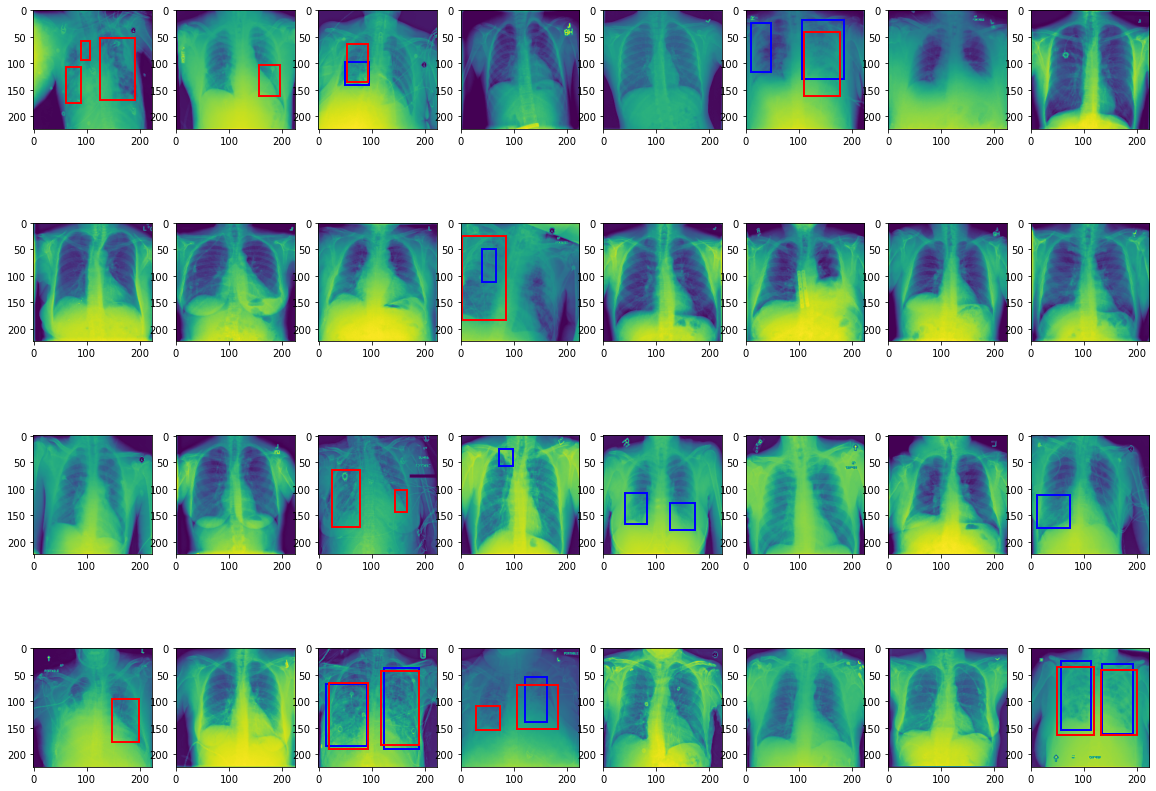

In [15]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

<font color='blue' size=4 ><b>
From the above output, i infer that the model's prediction is good, I will train for 5 more epochs to verify the the model's performance.(in total this is 10 epochs)

In [20]:
for layer in deepunetmodel.layers:
    layer.trainable = True
deepunetmodel.compile(optimizer='adam',
           loss=iou_loss,
           metrics=['accuracy', mean_iou])
 #fit the model for 5 epoch.
history = deepunetmodel.fit(train_gen,
                        validation_data=val_gen,
                        epochs=5,
                        verbose=1,
           callbacks=callbacks_list
 )

Epoch 1/5
759/759 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.9620 - mean_iou: 0.6458
Epoch 00001: val_accuracy improved from -inf to 0.96320, saving model to model.h5
759/759 [==============================] - 656s 864ms/step - loss: 0.7454 - accuracy: 0.9620 - mean_iou: 0.6458 - val_loss: 0.7992 - val_accuracy: 0.9632 - val_mean_iou: 0.6904
Epoch 2/5
759/759 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.9634 - mean_iou: 0.6549
Epoch 00002: val_accuracy did not improve from 0.96320
759/759 [==============================] - 606s 799ms/step - loss: 0.7298 - accuracy: 0.9634 - mean_iou: 0.6549 - val_loss: 0.9491 - val_accuracy: 0.9593 - val_mean_iou: 0.6744
Epoch 3/5
759/759 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.9645 - mean_iou: 0.6645
Epoch 00003: val_accuracy did not improve from 0.96320

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
759/759 [======================

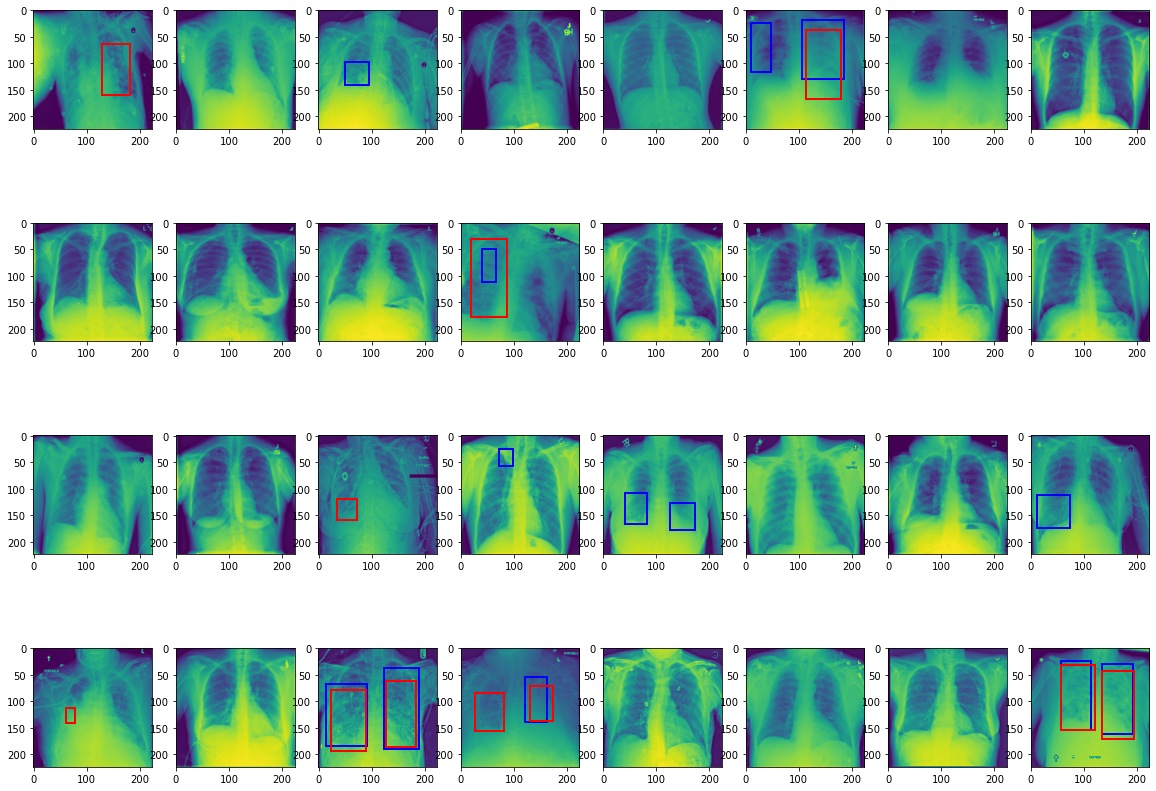

In [22]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

In [23]:
deepunetmodel.save_weights('deepunet_8_e10.h5')

Base Model
-------------------
Validation Accuracy:  0.8004032258064516
Validation Precision:  0.6835585585585585
Validation Recall:  0.6597826086956522
Validation F1-Score:  0.6714601769911505


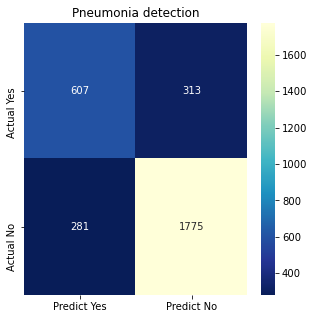

In [21]:
y_predval_deepunet = []
y_trueval_deepunet = []

 
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_deepunet.append(detectandMask(msk, False))
        y_predval_deepunet.append(detectandMask(pred))
        

printConfusionMatrix('Base Model', y_trueval_deepunet, y_predval_deepunet)

In [24]:
deepunet_maskpred = deepunetmodel.predict(test_gen, steps=300)
ytestpred_deepunet =[]
for mask in deepunet_maskpred:
    ytestpred_deepunet.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_deepunet, return_counts=True))

Pneumonia present: (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2248,  752]))


<font color='blue' size=4 ><b>
From the above output, i infer that the performance is improving. Thus, Training for 5 more epochs.(in total this is 15 epochs)

In [25]:
for layer in deepunetmodel.layers:
    layer.trainable = True
deepunetmodel.compile(optimizer='adam',
           loss=iou_loss,
           metrics=['accuracy', mean_iou])
 #fit the model for 5 epoch.
history = deepunetmodel.fit(train_gen,
                        validation_data=val_gen,
                        epochs=5,
                        verbose=1,
           callbacks=callbacks_list
 )

Epoch 1/5
759/759 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.9658 - mean_iou: 0.6739
Epoch 00001: val_accuracy did not improve from 0.96452
759/759 [==============================] - 583s 768ms/step - loss: 0.7116 - accuracy: 0.9658 - mean_iou: 0.6739 - val_loss: 0.7226 - val_accuracy: 0.9625 - val_mean_iou: 0.6670
Epoch 2/5
759/759 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.9659 - mean_iou: 0.6750
Epoch 00002: val_accuracy did not improve from 0.96452
759/759 [==============================] - 572s 753ms/step - loss: 0.7071 - accuracy: 0.9659 - mean_iou: 0.6750 - val_loss: 0.7580 - val_accuracy: 0.9617 - val_mean_iou: 0.6850
Epoch 3/5
759/759 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.9638 - mean_iou: 0.6524
Epoch 00003: val_accuracy did not improve from 0.96452

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
759/759 [==============================] - 577s 760ms/step

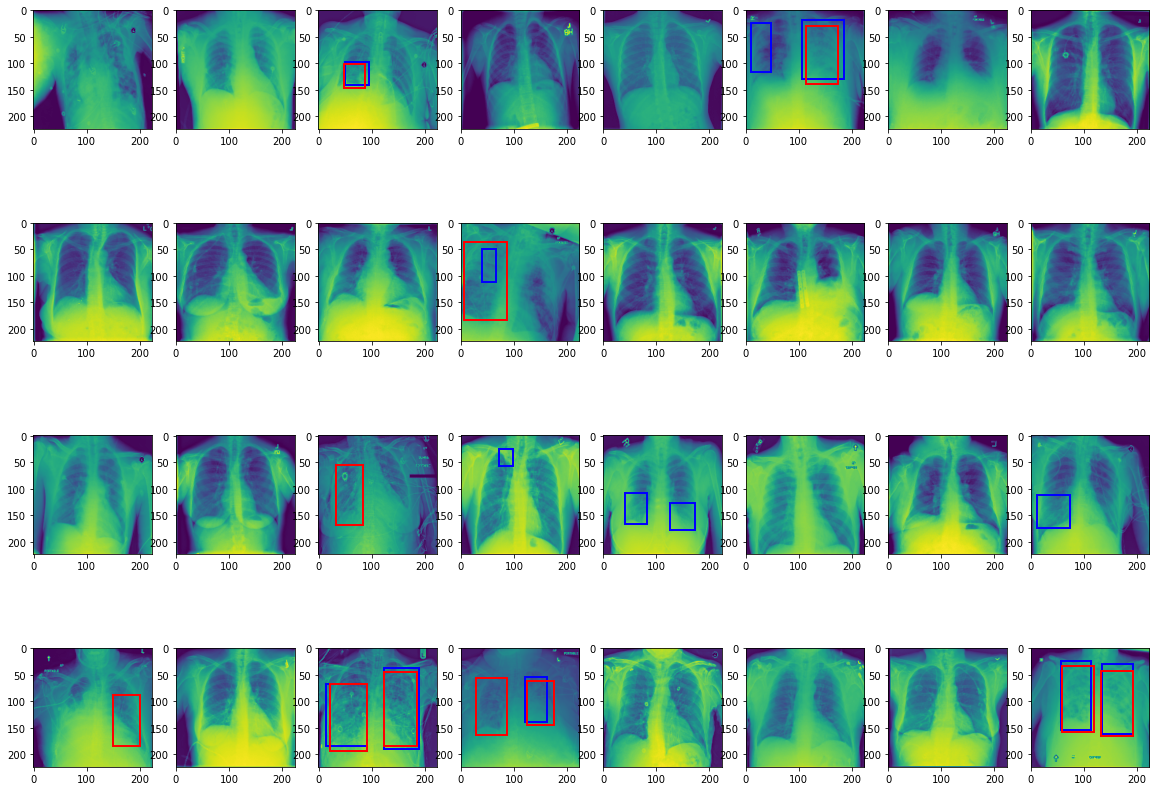

In [26]:
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img,msk, predm in zip(imgs,msks, preds):
        # plot image
        
        axarr[axidx].imshow(img[:, :, 0])
        detectandMask(msk,False, axarr[axidx])
        detectandMask(predm,True, axarr[axidx])
        axidx += 1
    plt.show()
    
    # only plot one batch
    break

Base Model
-------------------
Validation Accuracy:  0.8175403225806451
Validation Precision:  0.714448236632537
Validation Recall:  0.6826086956521739
Validation F1-Score:  0.69816564758199


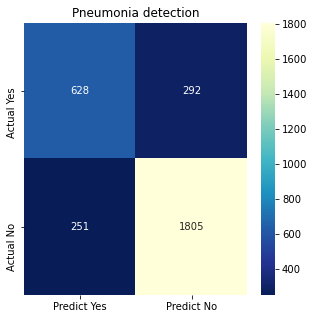

In [27]:
y_predval_deepunet = []
y_trueval_deepunet = []

 
for imgs, msks in val_gen:
    # predict batch of images
    preds = deepunetmodel.predict(imgs)
    
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        #  detect Pneumonia in mask actual & predicted
        y_trueval_deepunet.append(detectandMask(msk, False))
        y_predval_deepunet.append(detectandMask(pred))
        

printConfusionMatrix('Base Model', y_trueval_deepunet, y_predval_deepunet)

In [28]:
deepunet_maskpred = deepunetmodel.predict(test_gen, steps=300)
ytestpred_deepunet =[]
for mask in deepunet_maskpred:
    ytestpred_deepunet.append(detectandMask(mask))

print('Pneumonia present: (0 - Normal, 1 - Pneumonia)', np.unique(ytestpred_deepunet, return_counts=True))

Pneumonia present: (0 - Normal, 1 - Pneumonia) (array([0, 1]), array([2266,  734]))


In [29]:
deepunetmodel.save_weights('deepunet_8_e15.h5')

<font color='blue' > Insights:<br>
    When I visually compare the validation sample with predicted and original lung opacity marking, 
result from the model trained for 15 epochs are closer to the original. The evaluation metrics results also improved significantly. Further description added in the ProjectNotes_3.html

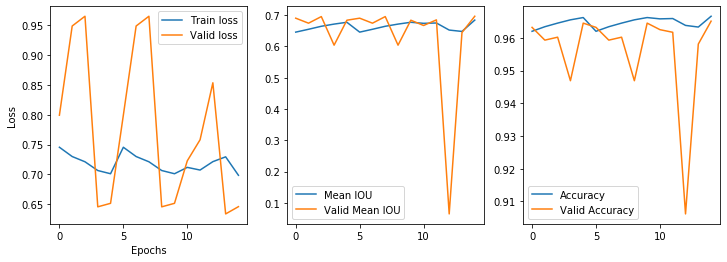

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(131)


plt.plot(np.arange(15), [0.7454, 0.7298, 0.7210, 0.7063 , 0.7009, 0.7454, 0.7298, 0.7210 , 0.7063, 0.7009, 0.7116, 0.7071, 0.7212, 0.7293, 0.6983  ], label="Train loss")
plt.plot(np.arange(15),[0.7992, 0.9491, 0.9655, 0.6453 , 0.6512, 0.7992, 0.9491, 0.9655 , 0.6453, 0.6512, 0.7226, 0.7580, 0.8537, 0.6334, 0.6456  ], label="Valid loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(np.arange(15),[0.6458, 0.6549, 0.6645, 0.6715 , 0.6773, 0.6458, 0.6549, 0.6645 , 0.6715, 0.6773, 0.6739, 0.6750, 0.6524, 0.6480, 0.6843  ], label="Mean IOU")
plt.plot(np.arange(15),[0.6904, 0.6744, 0.6955, 0.6041 , 0.6839, 0.6904, 0.6744, 0.6955 , 0.6041, 0.6839, 0.6670, 0.6850, 0.0644, 0.6446, 0.6966  ], label="Valid Mean IOU")
plt.legend()

plt.subplot(133)
plt.plot(np.arange(15),[0.9620, 0.9634, 0.9645, 0.9655 , 0.9662, 0.9620, 0.9634, 0.9645 , 0.9655, 0.9662, 0.9658, 0.9659, 0.9638, 0.9633, 0.9666  ], label="Accuracy")
plt.plot(np.arange(15),[0.9632, 0.9593, 0.9602, 0.9469 , 0.9645, 0.9632, 0.9593, 0.9602 , 0.9469, 0.9645, 0.9625, 0.9617, 0.9062, 0.9581, 0.9651  ], label="Valid Accuracy")
plt.legend()

plt.show()

In [ ]:
loss [0.7454, 0.7298, 0.7210, 0.7063 , 0.7009, 0.7454, 0.7298, 0.7210 , 0.7063, 0.7009, 0.7116, 0.7071, 0.7212, 0.7293, 0.6983  ]
accuracy [0.9620, 0.9634, 0.9645, 0.9655 , 0.9662, 0.9620, 0.9634, 0.9645 , 0.9655, 0.9662, 0.9658, 0.9659, 0.9638, 0.9633, 0.9666  ]
mean_iou [0.6458, 0.6549, 0.6645, 0.6715 , 0.6773, 0.6458, 0.6549, 0.6645 , 0.6715, 0.6773, 0.6739, 0.6750, 0.6524, 0.6480, 0.6843  ]
val_loss [0.7992, 0.9491, 0.9655, 0.6453 , 0.6512, 0.7992, 0.9491, 0.9655 , 0.6453, 0.6512, 0.7226, 0.7580, 0.8537, 0.6334, 0.6456  ]
val_accuracy [0.9632, 0.9593, 0.9602, 0.9469 , 0.9645, 0.9632, 0.9593, 0.9602 , 0.9469, 0.9645, 0.9625, 0.9617, 0.9062, 0.9581, 0.9651  ]
val_mean_iou [0.6904, 0.6744, 0.6955, 0.6041 , 0.6839, 0.6904, 0.6744, 0.6955 , 0.6041, 0.6839, 0.6670, 0.6850, 0.0644, 0.6446, 0.6966  ]


loss: 0.7454 - accuracy: 0.9620 - mean_iou: 0.6458 - val_loss: 0.7992 - val_accuracy: 0.9632 - val_mean_iou: 0.6904
loss: 0.7298 - accuracy: 0.9634 - mean_iou: 0.6549 - val_loss: 0.9491 - val_accuracy: 0.9593 - val_mean_iou: 0.6744
loss: 0.7210 - accuracy: 0.9645 - mean_iou: 0.6645 - val_loss: 0.9655 - val_accuracy: 0.9602 - val_mean_iou: 0.6955
loss: 0.7063 - accuracy: 0.9655 - mean_iou: 0.6715 - val_loss: 0.6453 - val_accuracy: 0.9469 - val_mean_iou: 0.6041
loss: 0.7009 - accuracy: 0.9662 - mean_iou: 0.6773 - val_loss: 0.6512 - val_accuracy: 0.9645 - val_mean_iou: 0.6839
loss: 0.7454 - accuracy: 0.9620 - mean_iou: 0.6458 - val_loss: 0.7992 - val_accuracy: 0.9632 - val_mean_iou: 0.6904
loss: 0.7298 - accuracy: 0.9634 - mean_iou: 0.6549 - val_loss: 0.9491 - val_accuracy: 0.9593 - val_mean_iou: 0.6744
loss: 0.7210 - accuracy: 0.9645 - mean_iou: 0.6645 - val_loss: 0.9655 - val_accuracy: 0.9602 - val_mean_iou: 0.6955
loss: 0.7063 - accuracy: 0.9655 - mean_iou: 0.6715 - val_loss: 0.6453 - val_accuracy: 0.9469 - val_mean_iou: 0.6041
loss: 0.7009 - accuracy: 0.9662 - mean_iou: 0.6773 - val_loss: 0.6512 - val_accuracy: 0.9645 - val_mean_iou: 0.6839
loss: 0.7116 - accuracy: 0.9658 - mean_iou: 0.6739 - val_loss: 0.7226 - val_accuracy: 0.9625 - val_mean_iou: 0.6670
loss: 0.7071 - accuracy: 0.9659 - mean_iou: 0.6750 - val_loss: 0.7580 - val_accuracy: 0.9617 - val_mean_iou: 0.6850
loss: 0.7212 - accuracy: 0.9638 - mean_iou: 0.6524 - val_loss: 0.8537 - val_accuracy: 0.9062 - val_mean_iou: 0.0644
loss: 0.7293 - accuracy: 0.9633 - mean_iou: 0.6480 - val_loss: 0.6334 - val_accuracy: 0.9581 - val_mean_iou: 0.6446
loss: 0.6983 - accuracy: 0.9666 - mean_iou: 0.6843 - val_loss: 0.6456 - val_accuracy: 0.9651 - val_mean_iou: 0.6966                     